# Fast Gradient Sign Method (FGSM) Adversarial Attack

This notebook demonstrates how to perform an **adversarial attack** using the **Fast Gradient Sign Method (FGSM)**.


## Intuition

Neural networks are vulnerable to small, carefully crafted perturbations added to the input.
FGSM perturbs the input in the direction of the gradient of the loss with respect to the input, scaled by a factor `ε`.

Mathematically:
\[
x_{adv} = x + \epsilon \cdot 	ext{sign}(
abla_x J(	heta, x, y))
\]

Where:
- \( x \): Original input
- \( y \): True label
- \( J(	heta, x, y) \): Loss function
- \( \epsilon \): Perturbation magnitude


In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader

from ml_utils import CustomDataset
from model.resnet_model import CNNClassifier

### Load the dataset

In [13]:
train_dt = CustomDataset(data_path=Path("../datasets/car_dataset"), portion="test")
train_loader = DataLoader(train_dt, batch_size=2, shuffle=True, num_workers=4)

### Load the pretrained model

In [14]:
cls = CNNClassifier(num_classes=196, pretrained=True, model_name="resnet18", freeze_layers=0)
cls.load_state_dict(torch.load("../webapp_result/r18_pretrained_freeze0/model.pth", weights_only=True))
cls.eval()

CNNClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Get the first batch of data

In [15]:
dt_iter = iter(train_loader)
X, y = next(dt_iter)

Set the gradient computation for the input tensor `X` to `True`.
This allows us to compute the gradient of the loss with respect to the input, which is necessary for the FGSM attack.

In [ ]:
X.requires_grad_(True)

Classify the input data and compute the loss.

In [ ]:
logits = cls(X)
loss = nn.CrossEntropyLoss()(logits, y)
cls.zero_grad()
loss.backward()

In [ ]:
y_prob = torch.softmax(logits, dim=1)
y_hat = torch.argmax(y_prob, dim=1)

The model confidence is the max probability of the predicted class.

In [26]:
print("Model confidence", [(y_prob[idx, i] * 100).item() for idx, i in enumerate(y_hat)])

Model confidence [88.3409652709961, 88.85916137695312]


Perform the FGSM attack by perturbing the input data in the direction of the gradient of the loss with respect to the input.
The perturbation is scaled by a factor of `0.007`, which is a hyperparameter that controls the magnitude of the perturbation.

In [ ]:
adv_img = X + .007 * torch.sign(X.grad)
with torch.no_grad():
    adv_logits = cls(adv_img)
    adv_y_prob = torch.softmax(adv_logits, dim=1)
    adv_y_hat = torch.argmax(adv_y_prob, dim=1)

In [27]:
print("Model confidence with adversarial images", [(adv_y_prob[idx, i] * 100).item() for idx, i in enumerate(y_hat)])

Model confidence with adversarial images [0.11830823123455048, 0.005824487656354904]


In [87]:

# X is the original input data, we have to clamp the values to be in the range [0, 1] for visualization.
# and permute the dimensions to match the expected input format for plotting.
X_plot = torch.clamp(X.detach(), 0, 1).permute(0, 2, 3, 1)
# The perturbation is the sign of the gradient, clamped to [0, 1] for visualization.
perturbation_plot = torch.clamp(torch.sign(X.grad), 0, 1).permute(0, 2, 3, 1)
# The adversarial images are also clamped to [0, 1] and permuted for visualization.
adv_plot = torch.clamp(adv_img.detach(), 0, 1).permute(0, 2, 3, 1)

top_labels = torch.argsort(-y_prob, dim=1)[:, :3]  # Get the top 3 predicted classes
# Get the indices of the top labels for each sample in the batch
row_indices = torch.arange(y_prob.shape[0]).unsqueeze(1).expand_as(top_labels)
# Get the probabilities of the top labels for each sample in the batch
top_dist = y_prob[row_indices, top_labels].detach()

adv_label = torch.argsort(-adv_y_prob, dim=1)
adv_top_labels = adv_label[:, :3]  # Get the top 3 predicted classes
# Get the indices of the top labels for each sample in the batch
adv_row_indices = torch.arange(adv_y_prob.shape[0]).unsqueeze(1).expand_as(adv_top_labels)
# Get the probabilities of the top labels for each sample in the batch
adv_top_dist = y_prob[adv_row_indices, adv_top_labels].detach()

# Create a tensor to store the delta positions of the adversarial labels. This will hold the difference in positions
# of the adversarial labels compared to the original top labels. For each sample in the batch, we will compute the
# difference in positions of the top labels and the adversarial labels. This will help us understand how the adversarial
# attack has changed the model's predictions.
delta_position = torch.zeros_like(top_labels)
for idx, i in enumerate(top_labels):
    for pos, j in enumerate(i):
        adv_pos = torch.nonzero(adv_label[idx] == j)
        delta = pos - adv_pos
        delta_position[idx, pos] = delta

all_dist_values = torch.concatenate([top_dist[0], top_dist[1], adv_top_dist[0], adv_top_dist[1]])
min_x = torch.min(all_dist_values[all_dist_values > 0])
max_x = torch.max(all_dist_values)

# params for better visualization
margin = 0.2
min_x_log = min_x * (1 - margin)
max_x_log = max_x * (1 + margin)

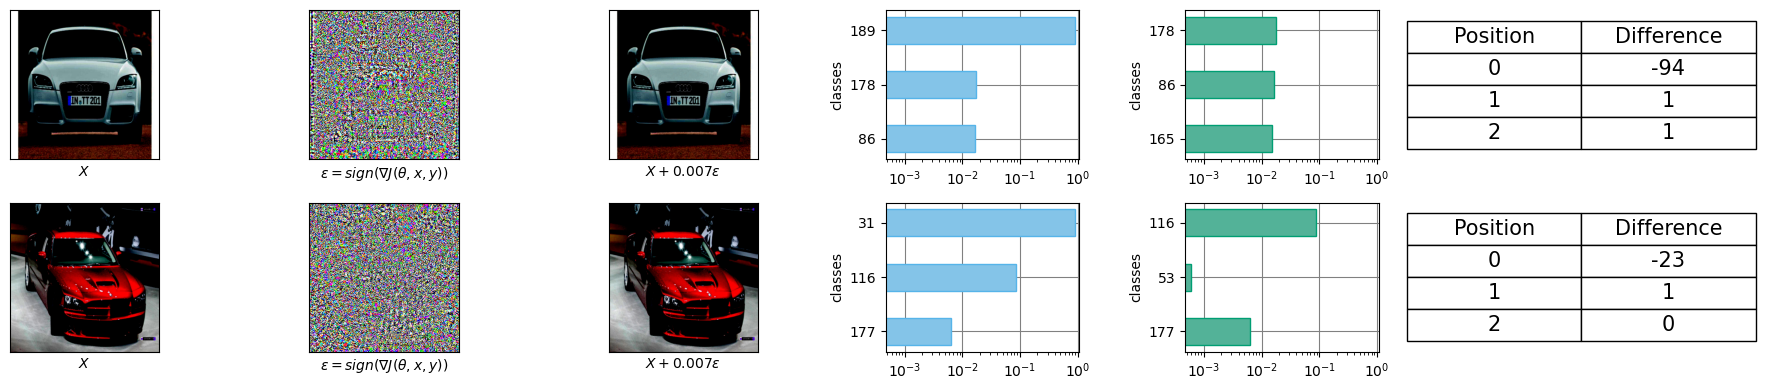

In [92]:
f, axs = plt.subplots(nrows=2, ncols=6, figsize=(18, 4))

for i in range(2):
    axs[i, 0].imshow(X_plot[i])
    axs[i, 0].set_xticks([]);
    axs[i, 0].set_yticks([])
    axs[i, 0].set_xlabel(r"$X$")

    axs[i, 1].imshow(perturbation_plot[i])
    axs[i, 1].set_xticks([]);
    axs[i, 1].set_yticks([])
    axs[i, 1].set_xlabel(r"$\epsilon = sign(\nabla J(\theta, x, y))$")

    axs[i, 2].imshow(adv_plot[i])
    axs[i, 2].set_xticks([]);
    axs[i, 2].set_yticks([])
    axs[i, 2].set_xlabel(r"$X + 0.007 \epsilon$")

    axs[i, 3].barh([str(i.item()) for i in reversed(top_labels[i])], reversed(top_dist[i]),
                   height=0.5, color="#84c4e8", edgecolor="#56B4E9")
    axs[i, 3].set_xlim(min_x_log, max_x_log)
    axs[i, 3].set_xscale("log")
    axs[i, 3].set_axisbelow(True)
    axs[i, 3].yaxis.grid(color='gray', linestyle='-')
    axs[i, 3].xaxis.grid(color='gray', linestyle='-')
    axs[i, 3].set_ylabel("classes")

    axs[i, 4].barh([str(i.item()) for i in reversed(adv_top_labels[i])], reversed(adv_top_dist[i]),
                   height=0.5, color="#53b298", edgecolor="#009E73")
    axs[i, 4].set_xlim(min_x_log, max_x_log)
    axs[i, 4].set_xscale("log")
    axs[i, 4].set_axisbelow(True)
    axs[i, 4].yaxis.grid(color='gray', linestyle='-')
    axs[i, 4].xaxis.grid(color='gray', linestyle='-')
    axs[i, 4].set_ylabel("classes")

    axs[i, 5].axis("off")  # hide axes
    table = axs[i, 5].table(
        cellText=[[pos, i.item()] for pos, i in enumerate(delta_position[i].unsqueeze(1).numpy())],
        colLabels=["Position", "Difference"],
        loc="center",
        cellLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(1.8, 1.8)

plt.savefig('imgs/adversarial_attack.png', dpi=300)
plt.savefig('imgs/adversarial_attack.pdf', dpi=300)
plt.tight_layout()
plt.show()